In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pickle

C:\Users\andre\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Cose da testare:

- a che numero secondi tagliare ogni audio
- spectogramma in dB o normale
- mfcc
- anzichè droppare tutti i segnali lunghi tagliare porzioni utili di audio lunghi 20 secondi ed aggiungerle a segnali audio brevi
- numero righe e colonne su cui splittare spectogramma
- applicare eventuale denoising 

## 1. Loading Dataset

In [2]:
path = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/development.csv'
df_development = pd.read_csv(path)
df_development

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40


In [3]:
#Evlauate balancement of dataset
df_development.action.value_counts(), df_development.object.value_counts()

(increase           3823
 decrease           3575
 change language    1113
 activate            791
 deactivate          552
 Name: action, dtype: int64,
 volume    5000
 heat      2398
 none      1113
 music      791
 lights     552
 Name: object, dtype: int64)

### Evaluate all the existing combinations in the dataset

In [4]:
#Evaluate all the existing combinations in the dataset
df_increase = df_development[df_development['action']=='increase']
df_increase.object.value_counts()

volume    2614
heat      1209
Name: object, dtype: int64

In [5]:
df_increase

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
6,6,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/6a1cd...,2BqVo8kVB2Skwgyb,increase,heat,advanced,English (United States),English (United States),female,22-40
7,7,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/72160...,2BqVo8kVB2Skwgyb,increase,heat,advanced,English (United States),English (United States),female,22-40
16,16,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/256b2...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9829,9829,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/37824...,Pz327QrLaGuxW8Do,increase,heat,native,English (United States),English (United States),female,22-40
9837,9837,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/98546...,Pz327QrLaGuxW8Do,increase,volume,native,English (United States),English (United States),female,22-40
9838,9838,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/a1b55...,Pz327QrLaGuxW8Do,increase,volume,native,English (United States),English (United States),female,22-40
9842,9842,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/1e8a9...,Pz327QrLaGuxW8Do,increase,heat,native,English (United States),English (United States),female,22-40


In [6]:
#Evaluate all the existing combinations in the dataset
df_decrease = df_development[df_development['action']=='decrease']
df_decrease.object.value_counts()

volume    2386
heat      1189
Name: object, dtype: int64

In [7]:
#Evaluate all the existing combinations in the dataset
df_change_language = df_development[df_development['action']=='change language']
df_change_language.object.value_counts()

none    1113
Name: object, dtype: int64

In [8]:
#Evaluate all the existing combinations in the dataset
df_activate = df_development[df_development['action']=='activate']
df_activate.object.value_counts()

music    791
Name: object, dtype: int64

In [9]:
#Evaluate all the existing combinations in the dataset
df_deactivate = df_development[df_development['action']=='deactivate']
df_deactivate.object.value_counts()

lights    552
Name: object, dtype: int64

Combinations of actions expressed by humans in the dataset found are the following:
1. increase volume
2. increase heat
3. decrease volume
4. decrease heat
5. change language
6. activate music
7. deactivate lights

According to this, starting from this dataset a new one can be generated containing the audio file with the corresponding label aside referring to the desired action.

### Creating new training dataset
Add a column called labels where in correspondance of each combination has the respective label (ex. if the row has action=increase and object=heat has label 1)

In [10]:
#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development['labels']=0

#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume'), 'labels']=1
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'heat'), 'labels']=2

df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'volume'), 'labels']=3
df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'heat'), 'labels']=4

df_development.loc[(df_development['action'] == 'change language') & (df_development['object'] == 'none'), 'labels']=5

df_development.loc[(df_development['action'] == 'activate') & (df_development['object'] == 'music'), 'labels']=6
df_development.loc[(df_development['action'] == 'deactivate') & (df_development['object'] == 'lights'), 'labels']=7

df_development
#df_development.labels.value_counts() #check

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,labels
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,6
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,7
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,1
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,1
...,...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,3
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,7


Now to generate a new dataset with recording and corresponding label assigned we need to extract every audio file looking ath the path column

In [11]:
path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
paths_recordings = df_development['path']

In [12]:
# signals = []
# sample_rates = []

# for path in paths_recordings:
#     file_path = f'{path_working_directory}/{path}'
    
#     signal, sr = librosa.load(file_path)
    
#     signals.append(signal)
#     sample_rates.append(sr)
    

In [13]:
# labels = df_development['labels']
# df = []
# df.append(paths_recordings)
# df.append(signals)
# df.append(sample_rates)
# df.append(labels)

In [14]:
# df=[]
# name_file = r'/df.pickle'
# print( path_working_directory+name_file)
# with open(path_working_directory+name_file, "wb") as output_file:
#     pickle.dump(df, output_file)

In [15]:
name_file = r'/df.pickle'

with open(path_working_directory+name_file, 'rb') as f:
        df = pickle.load(f)
#df


1.877324    525
1.792018    500
2.048027    493
1.962721    462
1.706712    448
           ... 
6.826712      1
5.120000      1
0.682721      1
6.656009      1
5.290703      1
Length: 124, dtype: int64
0       1.857642
1       1.393197
2       1.950522
3       1.764717
4       2.414875
          ...   
9849    2.730703
9850    2.645351
9851    2.645351
9852    2.304036
9853    2.816009
Length: 9854, dtype: float64


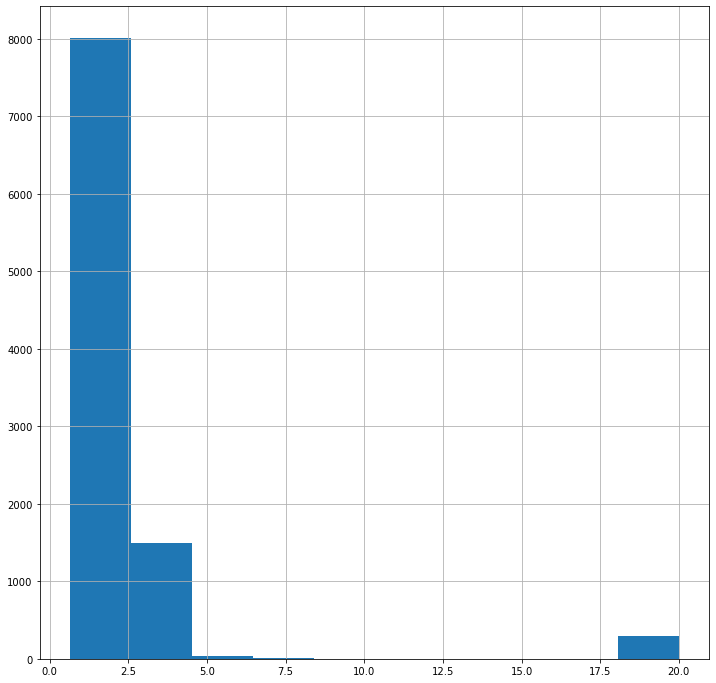

In [16]:
length_audios = []
length_audios_seconds = []
indexes = []
i = 0

for item,sr in zip(df[1], df[2]):
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
    if len(item)/sr  <=4:
        indexes.append(i)
    i = i+1
        

length_audios=pd.Series(length_audios)
length_audios_seconds = pd.Series(length_audios_seconds)
print(length_audios_seconds.value_counts())
plt.figure(figsize=(12,12))
length_audios_seconds.hist()
print(length_audios_seconds)


In [17]:
len(indexes)

9464

In [18]:
# length_audios = []
# length_audios_seconds = []
# indexes_to_drop = []
# i = 0

# for item,sr in zip(df[1], df[2]):
#     length_audios.append(len(item))
#     length_audios_seconds.append(len(item)/sr)
#     if len(item)/sr >= 4 and len(item)/sr <= 4.2:
#         indexes_to_drop.append(i)
#     i = i+1

In [19]:
# indexes_to_drop

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

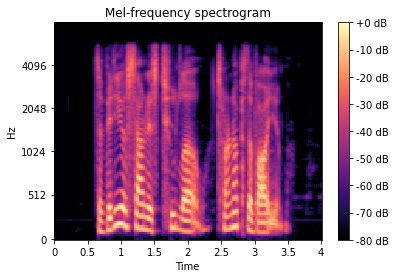

In [20]:
spectogram = librosa.feature.melspectrogram(y=df[1][1752], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [21]:
spectogram.shape

(128, 173)

In [23]:
s_rates = pd.Series(df[2])
s_rates.value_counts()

22050    9854
dtype: int64

Every signal has the same sample rate of 22050.

In [24]:
sample_rate = 22050

In [25]:
indexes

length_audios_seconds[7767] #8140, 8228]
print(length_audios_seconds.value_counts().iloc[:50])
length_audios_seconds.value_counts().iloc[:50].keys().drop(20).max()
length_audios_seconds.value_counts().iloc[:50].values.sum()
#[1752, 3671, 4234, 4675, 5669, 7111, 7767, 7843, 8888]

# cnt = 0
# for i in length_audios_seconds.value_counts().keys():
    
#     if i >=4.95 and i <=5.05:
#         print(i)
#         print(cnt)
#     cnt = cnt+1

1.877324     525
1.792018     500
2.048027     493
1.962721     462
1.706712     448
1.621315     434
2.218730     401
2.133333     395
2.389342     338
2.304036     323
20.000000    300
1.536009     296
1.764717     250
1.450703     245
2.560000     244
1.671837     241
2.474694     228
1.578957     214
1.857642     196
1.950522     185
2.730703     180
1.365351     176
2.043401     167
2.645351     165
1.486077     163
2.136281     143
2.816009     131
2.322041     121
2.901315     114
2.229161     112
1.280000     110
2.414875     105
1.393197     103
2.986712      91
2.507755      90
3.157324      81
2.600635      73
3.072018      73
3.328027      71
1.194694      64
1.300317      59
3.242721      55
1.109342      54
2.693515      53
2.786395      38
1.024036      36
2.879274      34
3.584036      33
2.972154      30
3.413333      29
dtype: int64


9472

## 2. Pre-Processing

There exist 9464 audio files (-300 of 20 seconds long) whose length is below 4 seconds, since the total of samples is 9857, it seems reasonable to cut take only the files whose length is lower or equal to 4 and then, in order to obtain comparable spectogram matrixes for every audio signal, the signals that present length < 4 are zero padded in the end in order to reach all audio signal of the same length (4) so also the matrices will be of the same size.

In [26]:
length_audios = []
length_audios_seconds = []
indexes_to_drop = []
i = 0

for item,sr in zip(df[1], df[2]):
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
    if len(item)/sr > 4:
        indexes_to_drop.append(i)
    i = i+1
        



In [27]:
len(indexes_to_drop)

390

In [28]:
df_pd = pd.DataFrame({'audio':df[1], 'label':df[3]})
df_pd

,audio,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",3
9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",7
9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",7
9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",7


In [29]:
df_pd=df_pd.drop(indexes_to_drop).reset_index(drop=True) #reset_index because we have a new df and if we want to iterate over it is simpler
df_pd

,audio,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...
9459,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",3
9460,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",7
9461,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",7
9462,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",7


Now retireve the max length of samples characterizing audio file (should be around 4 seconds) in order to pad every other array with lower dimension til the same length in order to have all audio file of the same length.

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

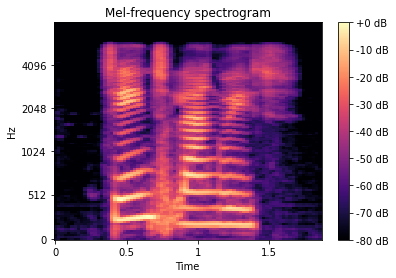

In [30]:
spectogram = librosa.feature.melspectrogram(y=df[1][0], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

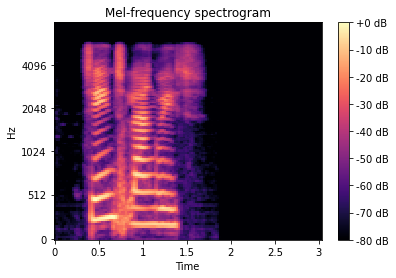

In [31]:
spectogram = librosa.feature.melspectrogram(y=np.pad(df_pd.audio[0],(0,88064- len(df_pd.audio[9463])),mode='constant', constant_values=0), sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [32]:
# Find maximum length of the audio in the dataframe
lengths = [len(audio) for audio in df_pd.audio]
# idx = 45 #check
# lengths[idx], len(df_pd.audio.iloc[idx])
lengths = pd.Series(lengths)
#lengths.max() #88064
lengths[lengths == lengths.max()]

3566    88064
4104    88064
dtype: int64

In [33]:
# def pad_audio(audio, max_length):
#     t = max_length - len(audio)
#     return np.pad(audio, pad_width=(0, t), mode='constant')

In [34]:
max_length = 88064
for i, audio in enumerate(df_pd.audio):
    
    #print(len(df_pd.audio[i]))
    #audio_padded = np.resize(df_pd.audio[i], max_length)
    df_pd.audio[i] = np.pad(df_pd.audio[i],(0,max_length- len(df_pd.audio[i])),mode='constant', constant_values=0)
    
    #print(len(df_pd.audio[i]))
#     if i == 2:
#         break

C:\Users\andre\AppData\Local\Temp/ipykernel_5676/2611756987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd.audio[i] = np.pad(df_pd.audio[i],(0,max_length- len(df_pd.audio[i])),mode='constant', constant_values=0)


In [35]:
lengths = [len(audio) for audio in df_pd.audio]
lengths = pd.Series(lengths)
lengths.value_counts()

88064    9464
dtype: int64

Test if audio has been correctly padded by checking if black background has been added on the right of the image

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

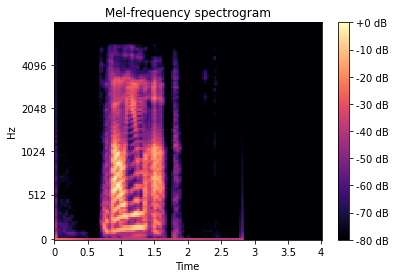

In [36]:
spectogram = librosa.feature.melspectrogram(y=df_pd.audio[9463], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')


Now that every audio signal has the same size and been correctly padded we can compute the spectogram matrix for each of them

In [38]:
spectograms = []
#the sprectograms obtained for these audios are 128x173 so we add 7 columns of 0 to get 128x180 matrices
tmp = np.zeros((spectogram.shape[0], 7))
for i, audio in enumerate(df_pd.audio):
    spectogram = librosa.feature.melspectrogram(y=df_pd.audio[i], sr=sample_rate)
    
    #adjust spectogram size to get nice number of columns that are easy to divide3
    spectogram= np.hstack((spectogram,tmp))
    spectograms.append(spectogram)
    #df_pd.audio['spectogram'] = spectogram
    
    #print(len(df_pd.audio[i]))
#     if i == 2:
#         break

In [ ]:
# x= spectograms[0].copy()
# tmp = np.zeros((spectograms[0].shape[0], 7))
# x=np.hstack((x,tmp))
# x.shape

In [39]:
df_pd['spectogram'] = spectograms

In [44]:
df_pd.spectogram[567].shape

(128, 180)

Now that we have obtained the spectogram of same dimension for every audio signal we can procede with the step of feature extraction.

## 3. Feature Extraction

For each spectogram of dimension RxC we need to divide it into a grid of rxc squares, each square will have dimensions R/r and C/c, so r and c will be hyperparameters.

Let's start by choosing r = c.

In [59]:
R, C = df_pd.spectogram[0].shape
width_row =  32 #128/8 = 16 -> each square will have height of 16
width_col = 30 #173/8 = 21.625 -> each square has width of 21.625 

In [60]:
R, C

(128, 180)

In [132]:
import numpy as np 

# Define the number of rows and columns for each submatrix 
rows = width_row 
cols = width_col
#df_means_stds = pd
#for audio_spectogram in df_pd.spectogram:
    
data = []


for audio_spectogram in df_pd.spectogram:
    
    means = []
    stds = []

    # Define the original matrix 
    original_matrix = audio_spectogram

    # Divide the original matrix into submatrices 
    submatrices = np.array([original_matrix[i:i+rows, j:j+cols] for i in range(0, original_matrix.shape[0], rows) for j in range(0, original_matrix.shape[1], cols)]) 

    for sub in submatrices:
        means.append(sub.mean())
        stds.append(sub.std())
    
    row_to_add = means + stds
    data.append(row_to_add)
new_df = pd.DataFrame(data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.364840,0.246298,1.296486e-03,0.000000,0.000000,0.0,0.005982,0.075857,2.407880e-06,0.000000e+00,...,2.443685e-03,0.000000e+00,0.000000e+00,0.0,5.648639e-03,6.861232e-03,1.321961e-03,0.000000e+00,0.000000e+00,0.0
1,0.251666,0.042410,4.938611e-09,0.000000,0.000000,0.0,0.003960,0.000463,1.675873e-09,0.000000e+00,...,1.984078e-09,0.000000e+00,0.000000e+00,0.0,3.643671e-03,3.624294e-06,8.694195e-10,0.000000e+00,0.000000e+00,0.0
2,0.008715,0.093598,1.493076e-03,0.000000,0.000000,0.0,0.000041,0.021074,1.352630e-03,0.000000e+00,...,9.152613e-04,0.000000e+00,0.000000e+00,0.0,7.505163e-08,7.911244e-08,7.991706e-04,0.000000e+00,0.000000e+00,0.0
3,0.131147,1.629733,3.029988e-03,0.000000,0.000000,0.0,0.156054,0.648627,8.353218e-05,0.000000e+00,...,1.192101e-05,0.000000e+00,0.000000e+00,0.0,2.570868e-04,2.963001e-02,8.442427e-08,0.000000e+00,0.000000e+00,0.0
4,0.000003,0.149189,1.141586e-01,0.005032,0.000000,0.0,0.000001,0.004752,2.098686e-03,3.281849e-05,...,1.445075e-04,3.359658e-06,0.000000e+00,0.0,2.160951e-08,8.289322e-08,1.490260e-07,3.992424e-08,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9459,0.012853,6.952745,3.682347e+00,0.001756,0.000000,0.0,0.000009,1.703094,8.302670e-01,1.651449e-06,...,3.819006e-02,5.444499e-06,0.000000e+00,0.0,1.856905e-06,3.818845e-04,8.238495e-04,1.065495e-06,0.000000e+00,0.0
9460,0.012990,4.450835,1.474628e+00,0.001074,0.000000,0.0,0.000034,1.819652,1.175710e-01,8.244789e-07,...,5.899858e-02,1.414214e-05,0.000000e+00,0.0,7.371839e-03,2.236103e-02,7.198993e-02,2.385671e-06,0.000000e+00,0.0
9461,1.230466,5.840946,1.571063e+00,0.001638,0.000000,0.0,0.367966,0.883062,1.003203e+00,1.156632e-06,...,6.346407e-03,2.268972e-05,0.000000e+00,0.0,1.569939e-03,1.100701e-01,2.271419e-03,2.694301e-06,0.000000e+00,0.0
9462,0.013410,4.753314,2.246866e-03,0.000381,0.000000,0.0,0.000012,1.525422,7.369280e-04,3.601185e-07,...,2.310928e-03,2.426344e-07,0.000000e+00,0.0,2.203178e-06,7.470186e-02,6.608306e-04,7.110079e-08,0.000000e+00,0.0


In [139]:
new_df['label'] = df_pd.label
new_df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,label
0,0.364840,0.246298,1.296486e-03,0.000000,0.000000,0.0,0.005982,0.075857,2.407880e-06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,5.648639e-03,6.861232e-03,1.321961e-03,0.000000e+00,0.000000e+00,0.0,5
1,0.251666,0.042410,4.938611e-09,0.000000,0.000000,0.0,0.003960,0.000463,1.675873e-09,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,3.643671e-03,3.624294e-06,8.694195e-10,0.000000e+00,0.000000e+00,0.0,6
2,0.008715,0.093598,1.493076e-03,0.000000,0.000000,0.0,0.000041,0.021074,1.352630e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,7.505163e-08,7.911244e-08,7.991706e-04,0.000000e+00,0.000000e+00,0.0,7
3,0.131147,1.629733,3.029988e-03,0.000000,0.000000,0.0,0.156054,0.648627,8.353218e-05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,2.570868e-04,2.963001e-02,8.442427e-08,0.000000e+00,0.000000e+00,0.0,1
4,0.000003,0.149189,1.141586e-01,0.005032,0.000000,0.0,0.000001,0.004752,2.098686e-03,3.281849e-05,...,3.359658e-06,0.000000e+00,0.0,2.160951e-08,8.289322e-08,1.490260e-07,3.992424e-08,0.000000e+00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9459,0.012853,6.952745,3.682347e+00,0.001756,0.000000,0.0,0.000009,1.703094,8.302670e-01,1.651449e-06,...,5.444499e-06,0.000000e+00,0.0,1.856905e-06,3.818845e-04,8.238495e-04,1.065495e-06,0.000000e+00,0.0,3
9460,0.012990,4.450835,1.474628e+00,0.001074,0.000000,0.0,0.000034,1.819652,1.175710e-01,8.244789e-07,...,1.414214e-05,0.000000e+00,0.0,7.371839e-03,2.236103e-02,7.198993e-02,2.385671e-06,0.000000e+00,0.0,7
9461,1.230466,5.840946,1.571063e+00,0.001638,0.000000,0.0,0.367966,0.883062,1.003203e+00,1.156632e-06,...,2.268972e-05,0.000000e+00,0.0,1.569939e-03,1.100701e-01,2.271419e-03,2.694301e-06,0.000000e+00,0.0,7
9462,0.013410,4.753314,2.246866e-03,0.000381,0.000000,0.0,0.000012,1.525422,7.369280e-04,3.601185e-07,...,2.426344e-07,0.000000e+00,0.0,2.203178e-06,7.470186e-02,6.608306e-04,7.110079e-08,0.000000e+00,0.0,7


In [136]:
#Check that mean and std are computed correctly
means = []
stds = []

# Define the original matrix 
original_matrix = df_pd.spectogram[2]

# Divide the original matrix into submatrices 
submatrices = np.array([original_matrix[i:i+rows, j:j+cols] for i in range(0, original_matrix.shape[0], rows) for j in range(0, original_matrix.shape[1], cols)]) 

for sub in submatrices:
    means.append(sub.mean())
    stds.append(sub.std())

row_to_add = means + stds
#row_to_add

## 4. Training and Validation

In [146]:
y = new_df['label']
X = new_df.drop(columns='label')
seed = 42

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((7571, 48), (1893, 48), (7571,), (1893,))

In [151]:
### RandomForest Regression ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def randforest_classifier(input_x, input_y, cv=10, seed = seed):
    ## Defining parameters
    model_RF= RandomForestClassifier(random_state =seed)

    parameters = {'n_estimators':[10, 50], 
                  'criterion':['gini', 'entropy'],
                  'max_features':['sqrt', 'log2']}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_RF = GridSearchCV(estimator=model_RF,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                        verbose = 15)

    ## Lastly, finding the best parameters.

    grid_search_RF.fit(input_x, input_y)
    best_parameters_RF = grid_search_RF.best_params_  
    best_score_RF = grid_search_RF.best_score_ 
    print(best_parameters_RF)
    print(best_score_RF)
    results = grid_search_RF.cv_results_
    
    return best_parameters_RF, results

best_params, RF_CV_results = randforest_classifier(X_train, y_train, 10, seed)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50}
0.4246424749828339


## Esperimenti a caso

In [24]:
# frame = 1024
# hop = frame//2 #integer division


In [39]:
# df[2]
# s_rate=pd.Series(df[2])
# s_rate.value_counts()

for item,sr in zip(df[1], df[2]):
    print(item, sr)
    break

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.9318040e-06
  3.8942535e-06  0.0000000e+00] 22050


In [149]:
index = 23#34#1#36#126        
#length_audios[length_audios==150000]
df[1][index]
print(df[3][index])
print(len(df[1][index]))
path_audio = df_development.path[index]
path_working_directory+'/'+path_audio
ipd.Audio(path_working_directory+'/'+path_audio)

1
86016


In [20]:
length_audios.loc[(length_audios<=50000)]# & (length_audios<=100000)]


0       40961
1       30720
2       43009
3       38912
5       49153
        ...  
9841    32768
9842    24577
9843    30720
9844    30720
9845    34816
Length: 6566, dtype: int64

In [59]:
df[1][1]

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -5.8157309e-07,  1.0317751e-06,  0.0000000e+00], dtype=float32)

In [61]:
len(indexes)

7685

Trying to visualize signals of different classes to see if there exist common patterns.

In [21]:
df_development[df_development['labels']==5].head()

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,labels
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5
47,47,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/ce762...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5
48,48,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/d6207...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5
49,49,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/d8f78...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5
50,50,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/db510...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,5


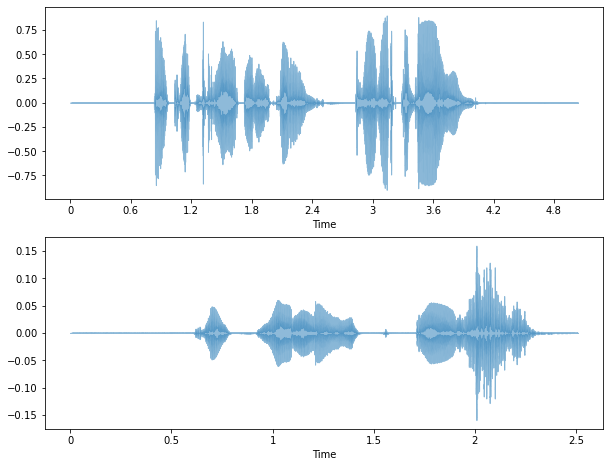

In [100]:
# index, label
#3,  1
#4,  1
#6,  2
#7,  2
#5,  3
#26, 3
#8,  4
#9,  4
#0,  5
#47, 5
#1,  6
#12, 6
#2,  7
#15, 7
plt.figure(figsize=(10, 12))

plt.subplot(3,1,1)
librosa.display.waveshow(df[1][8140], alpha=0.5)
plt.subplot(3,1,2)
librosa.display.waveshow(df[1][15], alpha=0.5)

# x = np.linspace(0, 10 - 2 * delta, 200) + delta
# fig, axs = plt.subplots(3, 7, figsize=(15,30), constrained_layout=True)
# for ax in axs:
#     ax.plot(x,df[1][3])

# plt.subplot(3,2,1)
# librosa.display.waveshow(df[1][6], alpha=0.5)
# plt.subplot(3,2,2)
# librosa.display.waveshow(df[1][7], alpha=0.5)
# small_df = []
# small_df.append(df[1][4])
# small_df

## 3.  Feature Extraction

In [25]:
spectogram = librosa.feature.melspectrogram(y=df[1][36], sr=sr)
spectogram.shape

(128, 862)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

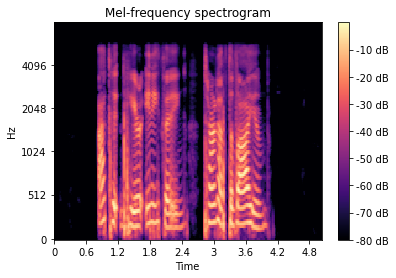

In [101]:
spectogram = librosa.feature.melspectrogram(y=df[1][8140], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(spectogram, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [102]:
df_spectogram = pd.DataFrame(spectogram)
df_spectogram.shape



(128, 217)

In [28]:
def compute_mean_std_spectogram(spectogram, R, C):
    
    
    
    for i in range(len(R)):
        for j in range(len(C)):
            

IndentationError: expected an indented block (Temp/ipykernel_1996/2413625022.py, line 7)

## 4. Classification